In [12]:
import numpy as np
import time
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
from untrade.client import Client
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
import talib as t
import warnings
import xgboost
import graphviz
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV
warnings.filterwarnings('ignore')

 ### XGBOOST IMPLEMENTATION  ###

In [15]:
class XGBoost:
    def __init__(self,df):
        self.df=df
        
    def compute_indicators(self): 
        
        # Relative Strength Index
        rsi_period=14
        self.df['RSI_14']=t.RSI(self.df['close'], timeperiod=rsi_period)

        #Moving Average Convergence Divergence
        _,_,self.df['MACD_diff']= t.MACD(self.df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

        #Average True Range
        atr_period=14
        self.df['ATR_14']=t.ATR(self.df['high'], self.df['low'], self.df['close'], timeperiod=atr_period)

        # Commodity Channel Index (CCI)
        cci_period = 20
        self.df['CCI_20'] = t.CCI(self.df['high'], self.df['low'], self.df['close'], timeperiod=cci_period)

        # TRIX (Triple Exponential Average)
        trix_period = 15
        self.df['TRIX_15'] = t.TRIX(self.df['close'], timeperiod=trix_period)

        # Mass Index
        mass_index_period = 25
        high_low_diff = self.df['high'] - self.df['low']
        ema_9 = t.EMA(high_low_diff, timeperiod=9)
        ema_ema_9 = t.EMA(ema_9, timeperiod=9)
        ema_ratio=ema_9/ema_ema_9
        self.df['Mass_Index_25'] = ema_ratio.rolling(window=mass_index_period).sum()

        # Detrended Price Oscillator (DPO)
        dpo_period = 20
        sma = t.SMA(self.df['close'], timeperiod=dpo_period)
        self.df['DPO_20'] = self.df['close'] - sma

        # KST Oscillator Difference from Signal Line
        kst = t.KAMA(self.df['close'], timeperiod=30) - t.EMA(self.df['close'], timeperiod=9)
        kst_signal = t.SMA(kst, timeperiod=9)
        self.df['KST_Diff_30'] = kst - kst_signal

        # Schaff Trend Cycle (STC)
        stc_period = 10
        fast_k = t.STOCHF(self.df['close'], self.df['high'], self.df['low'], fastk_period=stc_period)[0]
        self.df['STC_10'] = t.EMA(fast_k, timeperiod=stc_period)

        # Stochastic Oscillator
        stochastic_k, stochastic_d = t.STOCH(self.df['high'], self.df['low'], self.df['close'], fastk_period=14, slowk_period=3, slowd_period=3)
        self.df['Stochastic_K_14'] = stochastic_k
        self.df['Stochastic_D_14'] = stochastic_d

        # Ultimate Oscillator
        self.df['Ultimate_Oscillator'] = t.ULTOSC(self.df['high'], self.df['low'], self.df['close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)

        # Williams %R
        willr_period = 14
        self.df['Williams_%R_14'] = t.WILLR(self.df['high'], self.df['low'], self.df['close'], timeperiod=willr_period)

        # Awesome Oscillator
        ao_short_period = 5
        ao_long_period = 34
        median_price = (self.df['high'] + self.df['low']) / 2
        self.df['Awesome_Oscillator_5_34'] = t.SMA(median_price, timeperiod=ao_short_period) - t.SMA(median_price, timeperiod=ao_long_period)

        # Percentage Price Oscillator (PPO) Difference from Signal Line
        ppo = t.PPO(self.df['close'], fastperiod=12, slowperiod=26)
        ppo_signal = t.SMA(ppo, timeperiod=9)
        self.df['PPO_Diff_12_26'] = ppo - ppo_signal

        # Percentage Volume Oscillator (PVO) Difference from Signal Line
        pvo = t.PPO(self.df['volume'], fastperiod=12, slowperiod=26)
        pvo_signal = t.SMA(pvo, timeperiod=9)
        self.df['PVO_Diff_12_26'] = pvo - pvo_signal

        # Coefficient of Variance
        cov_period = 30
        rolling_std = self.df['close'].rolling(window=cov_period).std()
        rolling_mean = self.df['close'].rolling(window=cov_period).mean()
        self.df['Coefficient_of_Variance_30'] = (rolling_std / rolling_mean) * 100

        # Ulcer Index
        ulcer_index_period = 14
        max_price = self.df['close'].rolling(window=ulcer_index_period).max()
        squared_deviation = ((self.df['close'] - max_price) / max_price) ** 2
        self.df['Ulcer_Index_14'] = squared_deviation.rolling(window=ulcer_index_period).mean().apply(np.sqrt)
        
        # Chaikin Money Flow (CMF)
        fast_period = 3  
        slow_period = 20 
        cmf = t.ADOSC(self.df['high'], self.df['low'], self.df['close'], self.df['volume'], fastperiod=fast_period, slowperiod=slow_period)
        self.df['CMF_3_20'] = cmf 

        # Ease of Movement (EoM)
        distance_moved = (self.df['high'] + self.df['low']) / 2 - (self.df['high'].shift(1) + self.df['low'].shift(1)) / 2
        box_ratio = self.df['volume'] / (self.df['high'] - self.df['low'])
        self.df['Ease_of_Movement'] = distance_moved / box_ratio

        # Average Directional Index (ADX)
        adx_period = 14
        self.df['ADX_14'] = t.ADX(self.df['high'], self.df['low'], self.df['close'], timeperiod=adx_period)

        # Compute daily returns
        self.df['returns'] = self.df['close'].pct_change()

        # Create a column for trades: 1 if returns are positive, otherwise 0
        self.df['trades'] = (self.df['returns'] > 0).astype(int)

        self.df['datetime'] = pd.to_datetime(self.df['datetime'], format='%m-%d-%Y %H:%M', errors='coerce')
        self.df['datetime'] = self.df['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
        self.df['datetime'] = pd.to_datetime(self.df['datetime'], format='%Y-%m-%d %H:%M:%S')
        self.df = self.df.rename(columns={'datetime': 'timestamp'})
          
    def train_test_split(self):
        #train-test split
        tscv = TimeSeriesSplit(n_splits=5)
        for train_index, test_index in tscv.split(self.features,self.target):
            self.X_train, self.X_test = self.features.iloc[train_index], self.features.iloc[test_index]
            self.Y_train, self.Y_test = self.target.iloc[train_index], self.target.iloc[test_index]
        #train-val split
        self.val_split = int(len(self.X_train) * 0.9)
        self.X_val, self.Y_val = self.X_train[self.val_split:], self.Y_train[self.val_split:]
        self.X_train, self.Y_train = self.X_train[:self.val_split], self.Y_train[:self.val_split]
        
    def preprocessing(self):
        self.features=self.df.drop(columns=['Unnamed: 0', 'timestamp','close','open','high','low','returns','trades','volume'])
        self.features=self.features.drop(self.features.index[-1],axis=0)
        self.target=self.df['trades'].shift(-1)
        self.target=self.target.drop(self.target.index[-1],axis=0)
        self.df=self.df.drop(self.df.index[-1],axis=0)
        self.train_test_split()
    
    def randomized_search(self):
    
            self.param_grid = {
                'learning_rate': [0.01, 0.1, 1],
                'n_estimators': [100, 200, 300],
                'max_depth': [2, 4, 6],
                'colsample_bytree': [0.4, 0.6, 0.8],
                'subsample': [0.7, 0.8, 1.0],
                'alpha': [0.01, 0.1, 1],
                'reg_lambda': [0.01, 0.1, 1],
                'min_child_weight': [2, 8,14],
                'eta': [0.01, 0.1, 1],
            }
            
            self.random_search = RandomizedSearchCV(
                estimator=self.model,
                param_distributions=self.param_grid,
                n_iter=100, 
                scoring='neg_mean_absolute_error',
                cv=3,
                verbose=2,
                n_jobs=-1,
                random_state=42 
            )
            
            self.random_search.fit(self.X_train, self.Y_train, eval_set=[(self.X_val, self.Y_val)])
            
            print("Best Hyperparameters:", self.random_search.best_params_)
                    
        
    def create_model(self):
        #model created based on best hyperparameter values found using RandomizedSearchCV
        self.model=XGBClassifier(
               alpha=2,
               colsample_bytree=0.4,
               reg_lambda=2,
               learning_rate=0.01,
               min_child_weight=2,
               max_depth=2,
               eta=0.1,
               n_estimators=100,
               subsample=1,
               random_state=42, 
               use_label_encoder=False,
               early_stopping_rounds=100,
        )
        # self.randomized_search()

    def train_model(self):
           self.model.fit(self.X_train,self.Y_train,verbose=True,eval_set=[(self.X_val, self.Y_val)])
        
    def test_model(self):
          train_error= (self.model.predict(self.X_train) != self.Y_train).mean()
          train_win_ratio=1- train_error
          print(f"Win ratio on train set is {train_win_ratio:.2f}")
          test_error = (self.model.predict(self.X_test) != self.Y_test).mean()
          test_win_ratio= 1- test_error
          print(f"Win ratio on test set is {test_win_ratio:.2f}")
        
    def feature_importance(self):
        #plotting feature importance based on weight
        importance = self.model.get_booster().get_score(importance_type='weight')
        importance_df = pd.DataFrame(
        list(importance.items()), columns=['Feature', 'Importance']
        ).sort_values(by='Importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.title('XGBoost Feature Importance based on weight')
        plt.gca().invert_yaxis()
        plt.show()

        #plotting feature importance based on gain
        importance = self.model.get_booster().get_score(importance_type='gain')
        importance_df = pd.DataFrame(
        list(importance.items()), columns=['Feature', 'Importance']
        ).sort_values(by='Importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.title('XGBoost Feature Importance based on gain')
        plt.gca().invert_yaxis()
        plt.show()

    def plot_optimal_tree(self):
        dot = xgboost.to_graphviz(self.model, num_trees=0)
        dot.render('xgboost_tree', format='png', cleanup=True)
        
    def prediction(self,value):
        return self.model.predict(value)

    def return_df(self):
        return self.df
        

## Processing Data ##

In [18]:
def process_data(df):
    #training
    obj1= XGBoost(df=df)
    obj1.compute_indicators()
    obj1.preprocessing()
    obj1.create_model()
    obj1.train_model()
    obj1.test_model()
    obj1.feature_importance()
    obj1.plot_optimal_tree()
    
    # plotting the most optimal decision tree in the ensemble
    from IPython.display import Image
    Image(filename='xgboost_tree.png')

    #processing for signal generation
    
    obj2= XGBoost(df=df)
    obj2.compute_indicators()
    obj2.preprocessing()
    df=obj2.return_df()
    df['predicted_trade'] = obj1.prediction(obj2.features)
    #Moving Average for entry trade confirmation
    df['MA_Short'] = t.SMA(df['close'],timeperiod=9)
    df['MA_Long'] = t.SMA(df['close'], timeperiod=26)
    return df

### STRATEGY IMPLEMENTATION ###

In [21]:
def strat(df):
    class PnlCalculator:
        def __init__(self,stop_loss_multiplier):
            super().__init__()
            self.stop_loss_multiplier=stop_loss_multiplier
            
        def Crossover(self):
            start_time = time.time()
    
            # Initialize signals
            df['signals'] = 0
            in_trade_long = False
            in_trade_short = False
            entry_price_long = 0
            entry_price_short = 0
            
            #signal generation 
            for i in range(len(df)):
                if in_trade_long:
                    # Calculate trailing stop-loss based on ATR
                    atr_value = df['ATR_14'].iloc[i]
                    if(df['close'].iloc[i]>df['close'].iloc[i-1]):
                        stop_loss_price = max(df['close'].iloc[i] - (atr_value * self.stop_loss_multiplier),stop_loss_price)
                        
                    #exit long trade if stoploss is attained
                    if (df['close'].iloc[i] <= stop_loss_price):
                            df.at[i, 'signals'] = -1  # Exit long position
                            in_trade_long = False  # Reset the trade status
                            entry_price_long = 0  # Reset entry price
            
                elif in_trade_short:
                    # Calculate trailing stop-loss based on ATR
                    atr_value = df['ATR_14'].iloc[i]
                    if(df['close'].iloc[i]<df['close'].iloc[i-1]):
                        stop_loss_price = min(df['close'].iloc[i] + (atr_value * self.stop_loss_multiplier),stop_loss_price)
    
                    #exit long trade if stoploss is attained
                    if (df['close'].iloc[i] >= stop_loss_price):
                            df.at[i, 'signals'] = -2  # Exit short position
                            in_trade_short = False  # Reset the trade status
                            entry_price_short = 0  # Reset entry price
    
                #entry condition for long trade based on XGBoost prediction combined MA crossover confirmation
                elif (df['predicted_trade'].iloc[i]==1 and  df['MA_Short'].iloc[i]>df['MA_Long'].iloc[i]):
                
                    df.at[i, 'signals'] = 1  # Long signal
                    entry_price_long = df['close'].iloc[i]
                    in_trade_long = True
                    atr_value = df['ATR_14'].iloc[i]
                    stop_loss_price = entry_price_long - (atr_value * self.stop_loss_multiplier)
                    
                #entry condition for long trade based on XGBoost prediction combined MA crossover confirmation 
                elif ( df['predicted_trade'].iloc[i]==0 and df['MA_Short'].iloc[i]<df['MA_Long'].iloc[i]):
                    
                      df.at[i, 'signals'] = 2  # Short signal
                      entry_price_short = df['close'].iloc[i]
                      in_trade_short = True
                      atr_value = df['ATR_14'].iloc[i]
                      stop_loss_price = entry_price_short + (atr_value * self.stop_loss_multiplier)     
    
            df_1 = df.copy()
            long_open = False
            short_open = False
          
            #signal processing
            for index, row in df_1.iterrows():
                signal = row['signals']
    
                if signal == 2 and short_open:
                    df_1.at[index, 'signals'] = 0
                elif signal == 1 and long_open:
                    df_1.at[index, 'signals'] = 0
                elif signal == 1 and not long_open:
                    long_open = True
                elif signal == 2 and not short_open:
                    short_open = True
    
                elif signal == -1:
                    if long_open:
                        long_open = False
                    else:
                        df_1.at[index, 'signals'] = 0
                elif signal == -2:
                    if short_open:
                        short_open = False
                    else:
                        df_1.at[index, 'signals'] = 0
    
            df_1['signal'] = df_1['signals']
            

            for i in tqdm(range(len(df_1))):
                if df_1['signals'].iloc[i] == 2 :
                    df_1['signals'].iloc[i] = -1
                elif df_1['signals'].iloc[i] == -2 :
                    df_1['signals'].iloc[i] = 1

            
            tscv = TimeSeriesSplit(n_splits=5)
            for train_index, test_index in tscv.split(df_1):
                df_train,df_test = df_1.iloc[train_index] , df_1.iloc[test_index]
                
            df_1= df_1[df_1["signals"]!=0]
            df_test= df_test[df_test["signals"]!=0]
            
            df_1 = df_1.rename(columns={'timestamp': 'datetime'})
            df_1 = df_1.rename(columns={'signal': 'trade_type'})

            df_test = df_test.rename(columns={'timestamp': 'datetime'})
            df_test = df_test.rename(columns={'signal': 'trade_type'})
            
            end_time = time.time()
            time_taken = end_time - start_time
            print(f"Time taken to generate signals : {time_taken:.2f}")
            
            return df_1,df_test
            
    # Create an instance of PnlCalculator 
    pnl_calculator = PnlCalculator( 
        stop_loss_multiplier=14,
       ) 
    df_1,df_test= pnl_calculator.Crossover()
        
    return df_1,df_test


### Backtesting Using The SDK ###

In [24]:
def perform_backtest(csv_file_path):
    client = Client()

    # Perform backtest using the provided CSV file path
    result = client.backtest(
        jupyter_id="kchitizraj", 
        file_path=csv_file_path,
        leverage=1,
    )
    return result

In [26]:
def main():
    df=pd.read_csv('ETHUSDT_1h.csv')
    processed_data = process_data(df)
    result_data, test_result_data = strat(processed_data)
    csv_file_path = "results.csv"
    csv_file_path_test = "test_results.csv"
    result_data.to_csv(csv_file_path, index=False)
    test_result_data.to_csv(csv_file_path_test , index =False)
    
    backtest_result = perform_backtest(csv_file_path)
    for value in backtest_result:
       print(value)
    backtest_result = perform_backtest(csv_file_path_test)
    for value in backtest_result:
       print(value)
    
    

[0]	validation_0-logloss:0.69302
[1]	validation_0-logloss:0.69296
[2]	validation_0-logloss:0.69293
[3]	validation_0-logloss:0.69287
[4]	validation_0-logloss:0.69282
[5]	validation_0-logloss:0.69277
[6]	validation_0-logloss:0.69271
[7]	validation_0-logloss:0.69266
[8]	validation_0-logloss:0.69262
[9]	validation_0-logloss:0.69259
[10]	validation_0-logloss:0.69254
[11]	validation_0-logloss:0.69248
[12]	validation_0-logloss:0.69243
[13]	validation_0-logloss:0.69237
[14]	validation_0-logloss:0.69231
[15]	validation_0-logloss:0.69228
[16]	validation_0-logloss:0.69225
[17]	validation_0-logloss:0.69221
[18]	validation_0-logloss:0.69216
[19]	validation_0-logloss:0.69211
[20]	validation_0-logloss:0.69207
[21]	validation_0-logloss:0.69202
[22]	validation_0-logloss:0.69199
[23]	validation_0-logloss:0.69194
[24]	validation_0-logloss:0.69190
[25]	validation_0-logloss:0.69186
[26]	validation_0-logloss:0.69182
[27]	validation_0-logloss:0.69178
[28]	validation_0-logloss:0.69174
[29]	validation_0-loglos

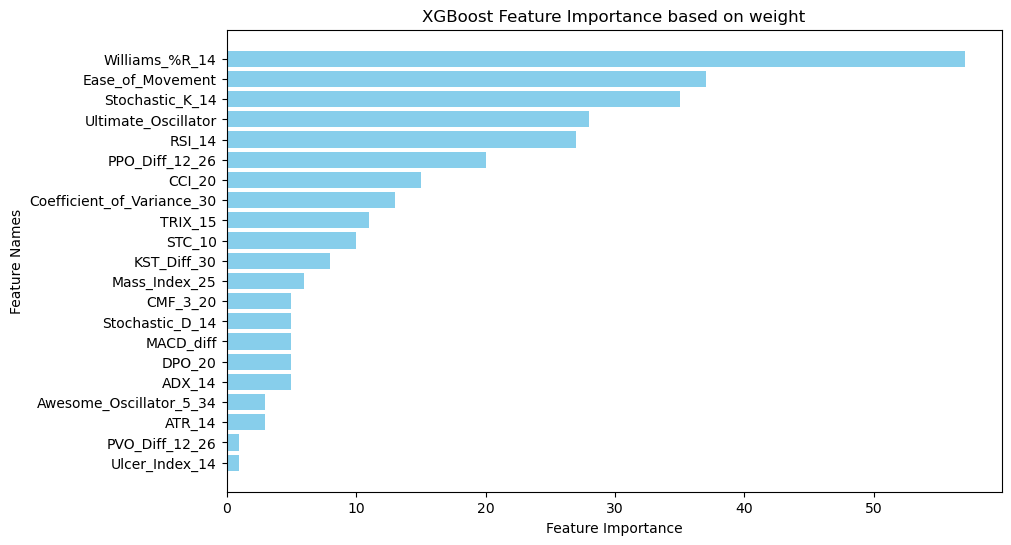

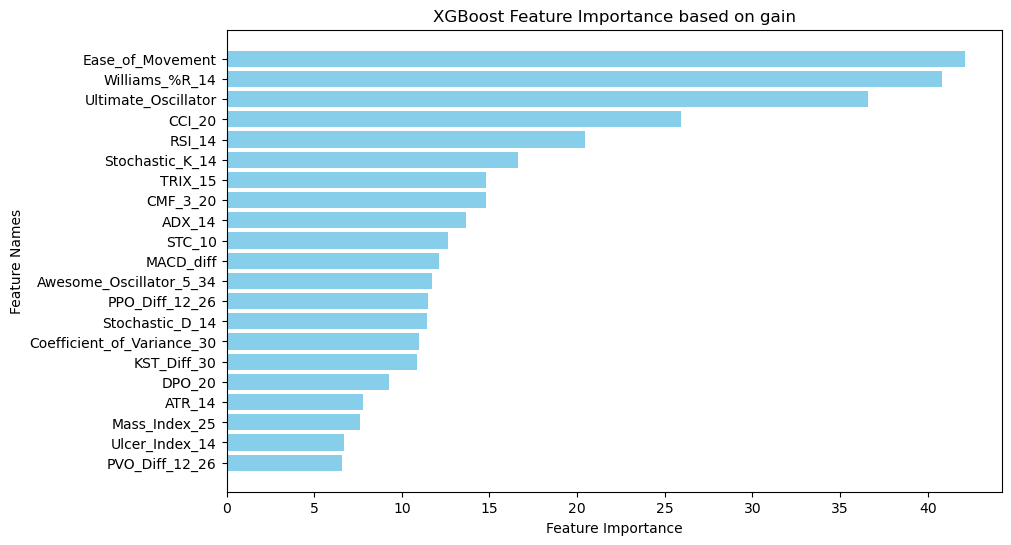

100%|█████████████████████████████████████████████████████████████████████████| 35064/35064 [00:00<00:00, 78860.58it/s]


Time taken to generate signals : 2.99
data: {
  "jupyter_id": "kchitizraj",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2020-01-02 01:00:00",
      "Total Trades": 55,
      "Leverage Applied": 1.0,
      "Winning Trades": 26,
      "Losing Trades": 29,
      "No. of Long Trades": 28,
      "No. of Short Trades": 27,
      "Benchmark Return(%)": 1748.33679,
      "Benchmark Return(on $1000)": 17483.367904,
      "Win Rate": 47.272727,
      "Winning Streak": 3,
      "Losing Streak": 4,
      "Gross Profit": 7734.087823,
      "Net Profit": 7651.587823,
      "Average Profit": 139.119779,
      "Maximum Drawdown(%)": 12.331209,
      "Average Drawdown(%)": 1.59101,
      "Largest Win": 2903.841905,
      "Average Win": 383.040548,
      "Largest Loss": -185.202124,
      "Average Loss": -79.567808,
      "Maximum Holding Time": "108 days 22:59:59",
      "Average Holding Time": "26 days 0:32:43",
      "Maximum Adv

In [28]:
if __name__ == "__main__":
     main()  